In [1]:
from PIL import Image
import numpy as np
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
#from google.colab import files
#uploaded = files.upload()

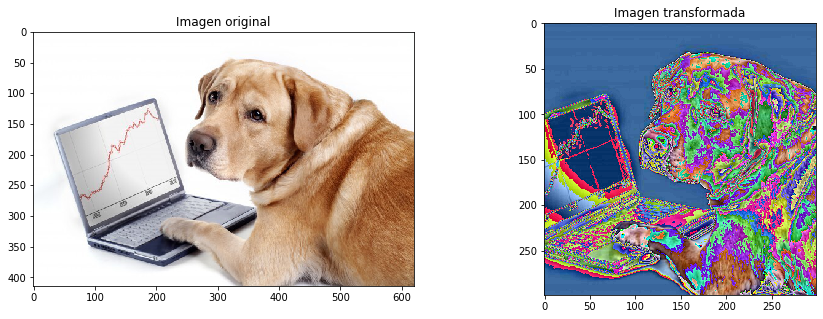

In [44]:
#Se importa la imagen y se le hacen las transformaciones correspondientes


transform = transforms.Compose([transforms.Resize(299),
                                transforms.CenterCrop(299),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])])

img=Image.open('P3_example.jpg').convert('RGB') 
img_t=transform(img)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Imagen original')
plt.imshow(img)
plt.subplot(1,2,2)
plt.title('Imagen transformada')
plt.imshow(transforms.ToPILImage()(img_t))
plt.show()

In [4]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import decode_predictions
from torchvision import models
import torch

#Se carga y entrena la red Inception V3

model= models.inception_v3(pretrained=True)
batch_t=torch.unsqueeze(img_t,0)



Using TensorFlow backend.


Predicted: [[('n02099712', 'Labrador_retriever', 8.534054), ('n03832673', 'notebook', 5.0214844), ('n02087394', 'Rhodesian_ridgeback', 4.7870183), ('n02099601', 'golden_retriever', 4.722911), ('n03642806', 'laptop', 4.489337), ('n02090379', 'redbone', 4.4610577), ('n02099849', 'Chesapeake_Bay_retriever', 3.6251726), ('n02115641', 'dingo', 3.5392838), ('n04409515', 'tennis_ball', 3.1472309), ('n06359193', 'web_site', 3.0407104)]]


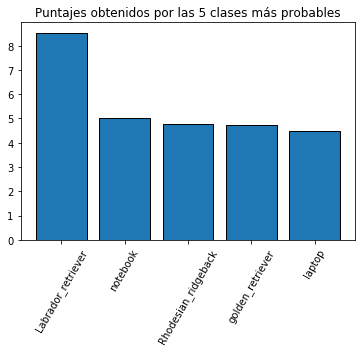

In [5]:
#Se hacen las predicciones para la imagen de control
#Se imprimen las diez primeras predicciones y se grafican los puntajes de los 
#5 primeros

model.eval()
preds = model(batch_t)
print('Predicted:', decode_predictions(preds.detach().numpy(), top=10))


labels=[]
scores=np.zeros(5)
for i in range(5):
    labels.append(decode_predictions(preds.detach().numpy(), top=10)[0][i][1])
    scores[i]=decode_predictions(preds.detach().numpy(), top=10)[0][i][2]

plt.bar(range(5), scores, edgecolor='black')

plt.xticks(range(5), labels, rotation=60)
plt.title("Puntajes obtenidos por las 5 clases más probables")
plt.show()

In [6]:
from skimage.segmentation import slic
#Crea el slic pedido, arreglo 299 x 299
slic_1=slic(transforms.ToPILImage()(img_t),n_segments=80)
n_cat=np.amax(slic_1)  #Se generaron 36 categorias (clusters del 0 al 35)

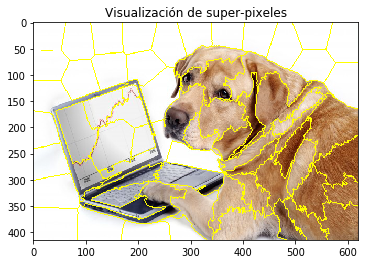

In [45]:
from skimage.segmentation import slic
from skimage import segmentation
#Visualizacion del Slic

slic = slic(img, n_segments=80)

plt.figure
plt.imshow(segmentation.mark_boundaries(img, slic))
plt.title('Visualización de super-pixeles')

plt.show()

In [8]:
#Crear perturbaciones

n_pert=1000

perturbaciones={} #Diccionario con las perturbaciones

for i in range (n_pert):
    perturbaciones[i]=np.random.binomial(size=n_cat+1, n=1, p= 0.5)



In [9]:

#Se crean las imagenes perturbadas, se guardan en el diccionario imgs_pert


imgs_pert={}
img_t_copy=img_t.detach().numpy()


#Para cada perturbacion, se le agrega una nueva capa a la imagen de control. 
#Esta nueva capa tiene el arreglo con los clusters, y en el caso que el cluster
#correspondiente tenga un 0 en la perturbación, se reemplaza el valor por un 999.
#En la imagen de control, si la nueva capa tiene un 999, se reemplazan todos los pixeles
#correspondientes por un 0.


for i in range(n_pert):
    aux=np.copy(slic_1)
    pert=perturbaciones[i]
    for j in range(n_cat+1):
        if pert[j]==0:
            aux[aux==j]=999
    img_pert=np.zeros((4,299,299))
    img_pert[0,:,:]=aux
    img_pert[[1,2,3],:,:]=img_t_copy
    img_pert[1][img_pert[0]==999]=0
    img_pert[2][img_pert[0]==999]=0
    img_pert[3][img_pert[0]==999]=0
    imgs_pert[i]=torch.tensor(img_pert[[1,2,3]],dtype=torch.float32)
      


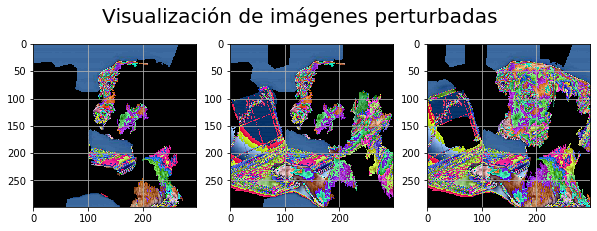

In [11]:
#Se muestran 3 imagenes perturbadas


fig, axs = plt.subplots(1, 3, figsize=(10, 3))
plt.suptitle('Visualización de imágenes perturbadas ',fontsize=20,x=0.5, y=1.05)
for ax, i in zip(axs, np.random.randint(1,1000,3)):
    ax.imshow(transforms.ToPILImage()(imgs_pert[i]))
    ax.grid(True)

plt.show()



In [12]:
#Se hacen las predicciones usando InceptionV3 para cada imagen perturbada, 
#y se forma el arreglo y, con un 1 si se clasifico como "labrador_retriever"
#y 0 si no

y=np.zeros(n_pert)
clas_expected=labels[0]


for i in range(n_pert):
    batch_t=torch.unsqueeze(imgs_pert[i],0)
    pred=model(batch_t)
    clas=decode_predictions(pred.detach().numpy())[0][0][1]
    if clas== clas_expected:
        y[i]=1


In [13]:
#Se calcula la distancia coseno y los pesos asociados a cada vector de perturbaciones vs. 
#el vector de perturbacion de la imagen de control (un vector de 1s)
from numpy import linalg as LA

sigma=0.25
dist=np.zeros(n_pert)

for i in range(n_pert):
    dist[i]=1 - np.dot(perturbaciones[i],np.ones(n_cat+1))/(LA.norm(perturbaciones[i])*LA.norm(np.ones(n_cat+1)))

pi=np.exp(-np.square(dist)/sigma**2)


In [14]:
#Se genera el conjunto de entrenamiento y se hace la regresion logistica
from sklearn.linear_model import LogisticRegression

D_p = np.zeros((n_pert,n_cat+1))

for i in range(n_pert):
    D_p[i]=perturbaciones[i]

clf = LogisticRegression()
clf.fit(D_p,y,sample_weight=pi)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

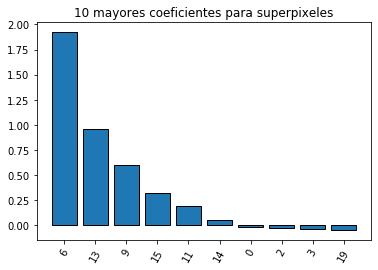

In [15]:
#Se obtienen los coeficientes del clasificador anterior
coef=np.std(D_p, 0)*clf.coef_

coef=coef.flatten()

#Se obtienen los 10 coeficientes con mayor valor
n=10
idx = (-coef).argsort()[:n]
#coef[idx]

plt.bar(range(n), coef[idx], edgecolor='black')
plt.xticks(range(n), idx, rotation=60)
plt.title("10 mayores coeficientes para superpixeles")
plt.show()

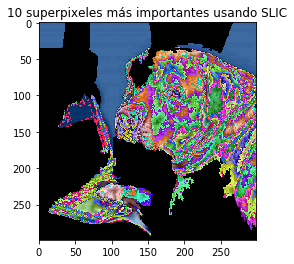

In [17]:
#Se genera una visualización de la imagen considerando solo los superpixeles 
#más importantes, encontrados en el paso anterior
img_t_copy=img_t.detach().numpy()
aux=np.copy(slic_1)

for i in range(n):
    aux[aux==idx[i]]=999

img_new=np.zeros((4,299,299))
img_new[0,:,:]=aux
img_new[[1,2,3],:,:]=img_t_copy
img_new[1][img_new[0] != 999]=0
img_new[2][img_new[0] != 999]=0
img_new[3][img_new[0] != 999]=0

img_new=torch.tensor(img_new[[1,2,3]],dtype=torch.float32)

plt.figure()
plt.imshow(transforms.ToPILImage()(img_new))
plt.title('10 superpixeles más importantes usando SLIC')
plt.show()



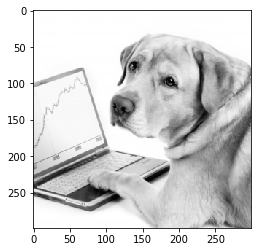

In [27]:
#Para hacer la clusterización, necesitamos la imagen en escala de grises



img_gray=transforms.Resize(299)(img)
img_gray=transforms.CenterCrop(299)(img_gray)
img_gray = np.mean(np.asarray(img_gray), axis=2, dtype=np.int32) #Se pasa a grises
img_gray = transforms.ToPILImage()(img_gray) 

plt.figure()
plt.imshow(img_gray, cmap="Greys_r")
plt.show()


In [19]:
#Se genera la matriz de entrenamiento, tiene 299*299 filas. 
#Cada fila tiene un arreglo de 3 dimensiones, donde la primera y la segunda
#representan la fila y columna de un pixel de la representación matricial de 
#la imagen, y la tercera es la intensidad de la escala de grises.


X_train=np.zeros((299*299,3))

for i in range(299):
    for j in range(299):
        row=np.zeros(3)
        row=([i , j, np.asarray(img_gray)[i][j] ])
        X_train[i*299 + j]=row


In [28]:
from sklearn.cluster import KMeans

#Clusterizaremos la matriz usando KMeans

kmeans = KMeans(n_clusters=40, random_state=5).fit(X_train)

In [29]:
kmeans_matrix=kmeans.labels_.reshape((299,299))

In [41]:
from sklearn.mixture import GaussianMixture

#Se clusteriza usando GaussianMixture

Gaussian = GaussianMixture(n_components=40, random_state=20).fit(X_train)

In [42]:
Gaussian_matrix = Gaussian.predict(X_train).reshape(299,299)

In [32]:
#Se replica el esquema LIME anterior, pero cambiando la matrix slic_1 
#usada anteriormente por las matrices nuevas después de Clusterizar


def Lime(n_pert,matrix,cluster_method, sigma=0.25, n_top=10):
  
    n_cat=np.amax(matrix)
    perturbaciones={} #Diccionario con las perturbaciones

    for i in range (n_pert):
        perturbaciones[i]=np.random.binomial(size=n_cat+1, n=1, p= 0.5)


  
    for i in range(n_pert):
        aux=np.copy(matrix)
        pert=perturbaciones[i]
        for j in range(n_cat+1):
            if pert[j]==0:
                aux[aux==j]=999
    img_pert=np.zeros((4,299,299))
    img_pert[0,:,:]=aux
    img_pert[[1,2,3],:,:]=img_t_copy
    img_pert[1][img_pert[0]==999]=0
    img_pert[2][img_pert[0]==999]=0
    img_pert[3][img_pert[0]==999]=0
    imgs_pert[i]=torch.tensor(img_pert[[1,2,3]],dtype=torch.float32)

    y=np.zeros(n_pert)
  
    for i in range(n_pert):
        batch_t=torch.unsqueeze(imgs_pert[i],0)
        pred=model(batch_t)
        clas=decode_predictions(pred.detach().numpy())[0][0][1]
        if clas== clas_expected:
            y[i]=1
  
    dist=np.zeros(n_pert)

    for i in range(n_pert):
        dist[i]=1 - np.dot(perturbaciones[i],np.ones(n_cat+1))/(LA.norm(perturbaciones[i])*LA.norm(np.ones(n_cat+1)))

    pi=np.exp(-np.square(dist)/sigma**2)

    D_p = np.zeros((n_pert,n_cat+1))

    for i in range(n_pert):
        D_p[i]=perturbaciones[i]

    clf = LogisticRegression()
    clf.fit(D_p,y,sample_weight=pi)

    coef=np.std(D_p, 0)*clf.coef_
    coef=coef.flatten()

 
    idx = (-coef).argsort()[:n_top]

    aux=np.copy(matrix)

    for i in range(n):
        aux[aux==idx[i]]=999

    img_new=np.zeros((4,299,299))
    img_new[0,:,:]=aux
    img_new[[1,2,3],:,:]=img_t_copy
    img_new[1][img_new[0] != 999]=0
    img_new[2][img_new[0] != 999]=0
    img_new[3][img_new[0] != 999]=0

    img_new=torch.tensor(img_new[[1,2,3]],dtype=torch.float32)

    plt.figure()
    plt.imshow(transforms.ToPILImage()(img_new))
    plt.title(str(n_top)+' superpixeles más importantes usando '+cluster_method)
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


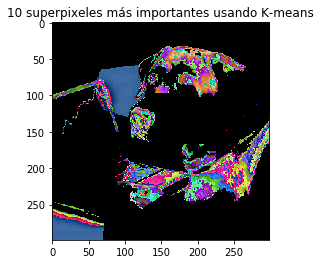

In [33]:
Lime(1000,kmeans_matrix,'K-means')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


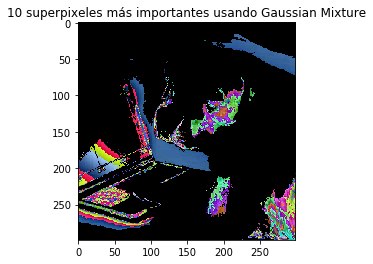

In [43]:
Lime(1000,Gaussian_matrix,'Gaussian Mixture')